In [1]:
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold,  RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from scipy import stats
from scipy.stats import boxcox,uniform 
import warnings

In [2]:
#Read in data
#from CSE6242_Data_Prep scripts
datCanc1 = pd.read_csv('data/cancer_brain_cleaned.csv') #pick cancer data set of choice
datPest = pd.read_csv('data/pesticide_pivot_all_cleaned.csv') #this is the same for all modeling

In [ ]:
#######################  DATA PREP ##############################

In [5]:
#use data for both sexes
#combine all cancer mortalities for each year/location into one sum mortality value
datCanc0 = datCanc1[(datCanc1['sex'] == 'Both')]
datCanc = datCanc0.groupby(['FIPS', 'YEAR'])['mx'].sum().reset_index(name='mx')

In [10]:
datNeoAll = datCanc.rename(columns = {'YEAR':'CancerYEAR'})
datNeoAll['PesticideYEAR'] = datNeoAll['CancerYEAR'] -5
#drop all colums except FIPS and the endpoint/ "mx" --> MORTALITY
datNeoMod = datNeoAll[['FIPS', 'PesticideYEAR','mx']].sort_values('FIPS', ascending=True)
datNeoMod.info()

In [13]:
datPest.info() #77380

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Columns: 1026 entries, YEAR to EPEST_LOW_KG_ZOXAMIDE
dtypes: float64(1024), int64(2)
memory usage: 605.7 MB


In [14]:
#datPestAll = datPest[(datPest['YEAR'] == 2000)]
datPestAll = datPest
datPestMod = datPestAll.rename(columns = {'YEAR':'PesticideYEAR'})

In [15]:
#join and keep data only in both data sets (i.e. that we have cancer mortality rates AND pesticide data for)
datMod = pd.merge(
    left=datNeoMod, 
    right=datPestMod,
    how='inner',
    left_on=['FIPS', 'PesticideYEAR'],
    right_on=['FIPS', 'PesticideYEAR']
)

#drop FIPS
data = datMod.drop(columns = ['FIPS', 'PesticideYEAR'])

In [18]:
####################### Feature Selection ##############################

In [19]:
#remove correlated independent  variables
threshold = 0.8
Xcorr = data.drop(columns = ['mx'])
corr_matrix = Xcorr.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

In [20]:
data1 = data.drop(columns=to_drop)

In [211]:
#t test
names = data1.loc[ : , data1.columns != 'mx'].columns
p_val = []
for i in names:
    t_statistic, p_value = stats.ttest_ind(data1['mx'], data1[i])
    #print(f"Compound: {i},T-statistic: {t_statistic}, P-value: {p_value}")
    p_val.append([i,t_statistic,p_value])

p_values = pd.DataFrame(p_val,  columns=["Compound", "T_statistic", "P_value"])
p_values_drop = p_values[p_values.P_value >= 0.01]

In [24]:
data2 = data1.drop(columns=p_values_drop['Compound'])

In [26]:
#feature selection Random Forest Variable Importance
#1000 randomly selected obsservations
datFs = data2.sample(n=1000)
XFs, yFs = datFs.drop(columns = ['mx']), datFs['mx']
#scale
scaler = StandardScaler()
XFsScale = scaler.fit_transform(XFs)

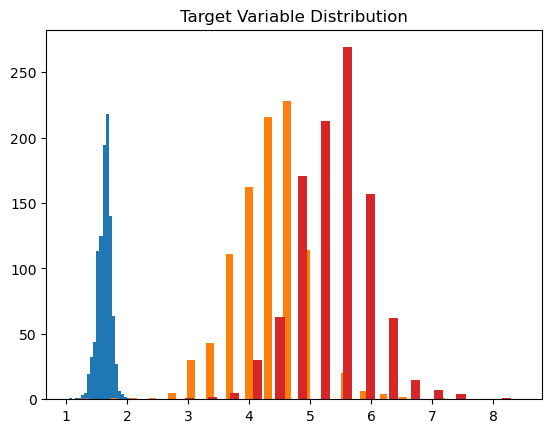

In [27]:
plt.hist(np.log(yFs), bins=20)
plt.hist(boxcox(yFs), bins=20)
plt.hist(stats.yeojohnson(yFs), bins=20)
plt.title("Target Variable Distribution")
plt.show()

In [28]:
from scipy.stats import skew, kurtosis

y_log = np.log(yFs)
y_bc, _ = boxcox(yFs)
y_yj, _ = stats.yeojohnson(yFs)

print("Log skew:", skew(y_log), "Log kurtosis:", kurtosis(y_log))
print("Box-Cox skew:", skew(y_bc), "Box-Cox kurtosis:", kurtosis(y_bc))
print("Yeo-Johnson skew:", skew(y_yj), "Yeo-Johnson kurtosis:", kurtosis(y_yj))

Log skew: -0.4959589501702825 Log kurtosis: 1.4890498107955956
Box-Cox skew: 0.03917989872263722 Box-Cox kurtosis: 1.1004711185661415
Yeo-Johnson skew: 0.03281227380177391 Yeo-Johnson kurtosis: 1.0980758781241242


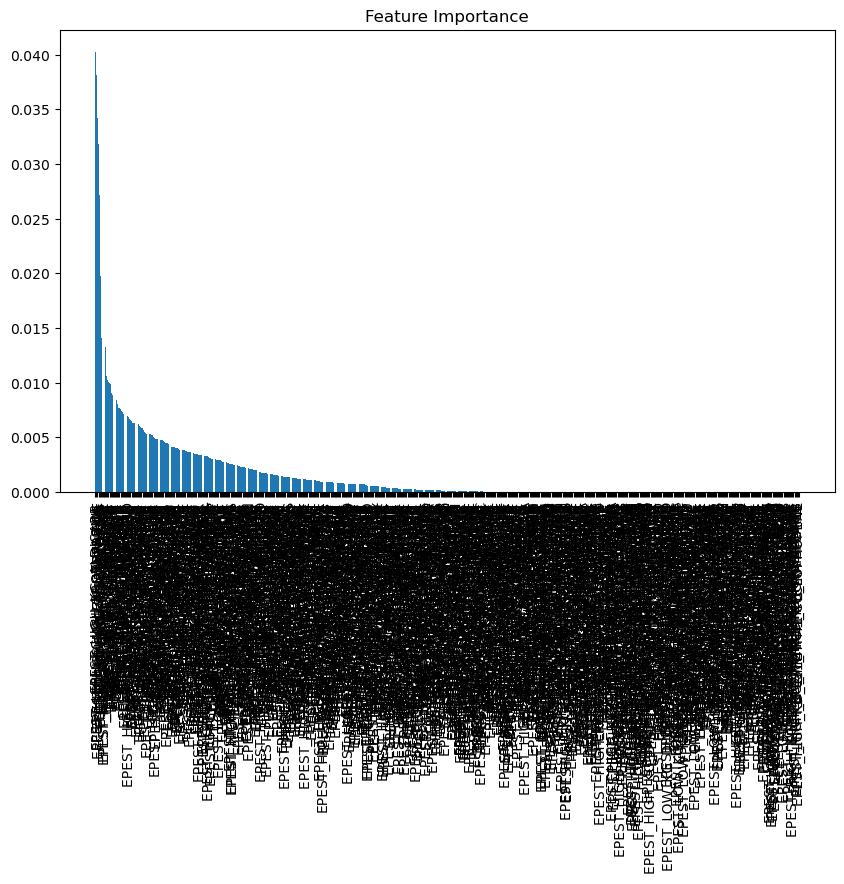

In [29]:
#Check feature importance using a simple Random Forest Regressor:
rf = RandomForestRegressor(n_estimators=100, random_state=123)
rf.fit(XFsScale, yFs)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(XFsScale.shape[1]), importances[indices])
plt.xticks(range(XFsScale.shape[1]), np.array(XFs.columns)[indices], rotation=90)
plt.title("Feature Importance")
plt.show()

In [30]:
# Get feature importances from the trained Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Set cutoff 
#Drop features with importance < 0.002 (roughly 1/6 of the max).
cutoff = 0.002
selected_features = np.array(XFs.columns)[importances > cutoff]

# Subset data
XFs_selected = XFs[selected_features]

print(f"Selected {len(selected_features)} features out of {XFs.shape[1]}")

Selected 145 features out of 641


In [31]:
#extract features from dataset (NOT SCALED/TRANSFORMED)
data3 = data2[selected_features]
data3 = pd.concat([data2['mx'], data3], axis=1)

In [101]:
# List model features  --> copy and paste into execl appendix table, remove "mx"
print(data3.columns.tolist()) 

['mx', 'EPEST_HIGH_KG_2,4-D', 'EPEST_HIGH_KG_2,4-DB', 'EPEST_HIGH_KG_ACEPHATE', 'EPEST_HIGH_KG_ACETOCHLOR', 'EPEST_HIGH_KG_ACIFLUORFEN', 'EPEST_HIGH_KG_ALACHLOR', 'EPEST_HIGH_KG_ALDICARB', 'EPEST_HIGH_KG_AMETRYN', 'EPEST_HIGH_KG_AMINOPYRALID', 'EPEST_HIGH_KG_ATRAZINE', 'EPEST_HIGH_KG_AZINPHOS-METHYL', 'EPEST_HIGH_KG_AZOXYSTROBIN', 'EPEST_HIGH_KG_BACILLUS THURINGIENSIS', 'EPEST_HIGH_KG_BENSULIDE', 'EPEST_HIGH_KG_BENTAZONE', 'EPEST_HIGH_KG_BIFENTHRIN', 'EPEST_HIGH_KG_BROMOXYNIL', 'EPEST_HIGH_KG_BUTYLATE', 'EPEST_HIGH_KG_CAPTAN', 'EPEST_HIGH_KG_CARBARYL', 'EPEST_HIGH_KG_CARBOFURAN', 'EPEST_HIGH_KG_CARFENTRAZONE-ETHYL', 'EPEST_HIGH_KG_CHLORETHOXYFOS', 'EPEST_HIGH_KG_CHLORIMURON', 'EPEST_HIGH_KG_CHLOROPICRIN', 'EPEST_HIGH_KG_CHLOROTHALONIL', 'EPEST_HIGH_KG_CHLORPYRIFOS', 'EPEST_HIGH_KG_CHLORSULFURON', 'EPEST_HIGH_KG_CLETHODIM', 'EPEST_HIGH_KG_CLOMAZONE', 'EPEST_HIGH_KG_CLOPYRALID', 'EPEST_HIGH_KG_COPPER HYDROXIDE', 'EPEST_HIGH_KG_COPPER OXYCHLORIDE S', 'EPEST_HIGH_KG_COPPER SULFATE', 'EPEST

In [34]:
 ########################### Train-Test-Validation Split ###########################

In [35]:
#Train-Test-Validation Split (70-15-15)
X, y = data3.drop(columns = ['mx']), data3['mx']

X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

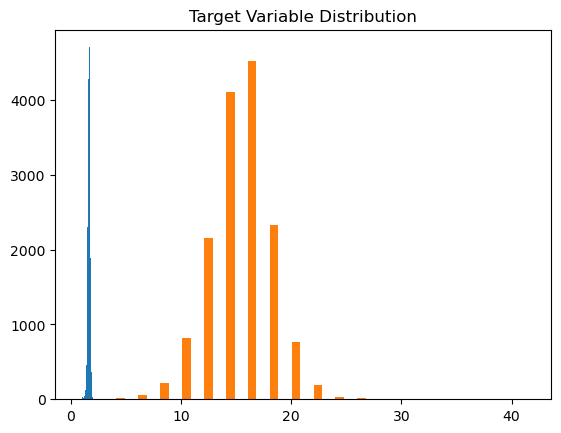

In [36]:
plt.hist(np.log(y_train_temp), bins=20)
plt.hist(stats.yeojohnson(y_train_temp), bins=20)
plt.title("Target Variable Distribution")
plt.show()

In [37]:
################# TRAINING #######################

In [38]:
#Scale/Transform variables
#StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY, so that each column/feature/variable will have μ = 0 and σ = 1.
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train_temp)
X_train_scaled = pd.DataFrame(scaled_X, columns = X_train_temp.columns)

#Transform Target Variable (Use yeojohnson)
y_train_scaled, lam = stats.yeojohnson(y_train_temp + 1e-6)

In [40]:
# define model
modelRF_train = RandomForestRegressor(n_estimators=100, random_state=123, oob_score=True)
# define model evaluation method (three repeats of 5-fold cross-validation)
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
scoresRF = cross_val_score(modelRF_train, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scoresRF = abs(scoresRF)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scoresRF), np.std(scoresRF)))

Mean MAE: 1.460 (0.026)


In [41]:
# Get predicted values
modelRF_train.fit(X_train_scaled, y_train_scaled)
y_predRF = modelRF_train.predict(X_train_scaled)

In [42]:
# Calculate residuals
residualsRF = y_train_scaled - y_predRF

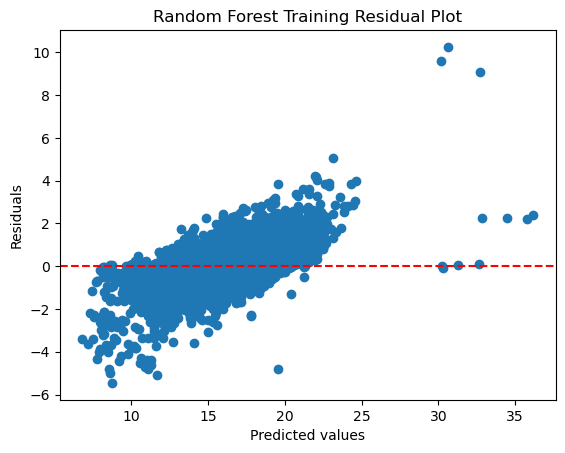

In [43]:
# Create the residual plot
plt.scatter(y_predRF, residualsRF)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Random Forest Training Residual Plot')
plt.show()

In [44]:
# define model
modelXG_train = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)
# define model evaluation method (three repeats of 5-fold cross-validation)
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
scoresXG = cross_val_score(modelXG_train, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scoresXG = abs(scoresXG)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scoresXG), np.std(scoresXG)))

Mean MAE: 1.514 (0.024)


In [45]:
# Get predicted values
modelXG_train.fit(X_train_scaled, y_train_scaled)
y_predXG = modelXG_train.predict(X_train_scaled)
# Calculate residuals
residualsXG = y_train_scaled - y_predXG

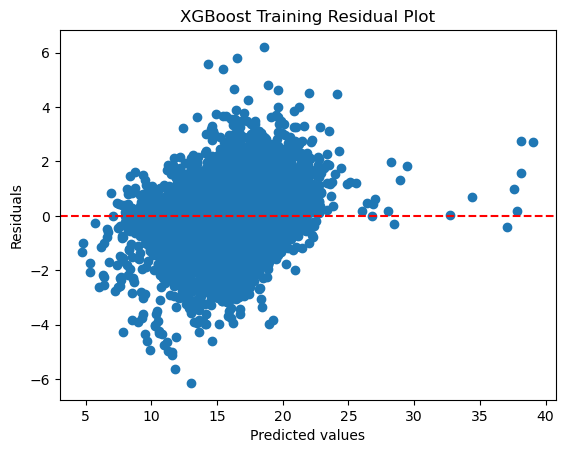

In [46]:
# Create the residual plot
plt.scatter(y_predXG, residualsXG)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('XGBoost Training Residual Plot')
plt.show()

In [69]:
# define model
modelSVR_train = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# define model evaluation method (three repeats of 5-fold cross-validation)
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
scoresSVR = cross_val_score(modelSVR_train, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scoresSVR = abs(scoresSVR)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scoresSVR), np.std(scoresSVR)))

Mean MAE: 1.880 (0.033)


In [71]:
# Get predicted values
modelSVR_train.fit(X_train_scaled, y_train_scaled)
y_predSVR = modelSVR_train.predict(X_train_scaled)
# Calculate residuals
residualsSVR = y_train_scaled - y_predSVR

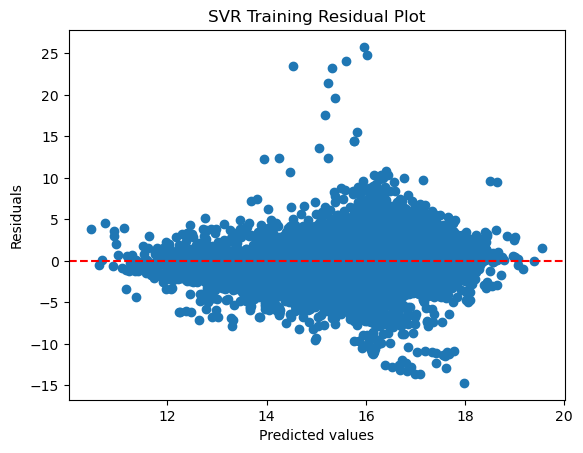

In [73]:
# Create the residual plot
plt.scatter(y_predSVR, residualsSVR)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('SVR Training Residual Plot')
plt.show()

In [ ]:
################# VALIDATION #######################

In [75]:
#StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY, so that each column/feature/variable will have μ = 0 and σ = 1.
scaler = StandardScaler()
scaled_Xval = scaler.fit_transform(X_val)
X_val_scaled = pd.DataFrame(scaled_Xval, columns = X_train_temp.columns)

#Transform Target Variable 
y_val_scaled = stats.yeojohnson(y_val + 1e-6, lmbda=lam)

In [77]:
X_val_scaled.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266 entries, 0 to 3265
Columns: 145 entries, EPEST_HIGH_KG_2,4-D to EPEST_LOW_KG_THIOPHANATE-METHYL
dtypes: float64(145)
memory usage: 3.6 MB


In [79]:
#Random Forest Regression
# define model
modelRF_val = RandomForestRegressor(random_state=123, oob_score=True)

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [3, 5, 7, 9, None],  # None means no maximum depth
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

grid_searchRF = RandomizedSearchCV(
    estimator=modelRF_val,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings to sample
    scoring='neg_mean_absolute_error',
    cv=5,       # or any CV strategy you prefer
    random_state=123,
    n_jobs=-1   # Use all available cores
)

grid_searchRF.fit(X_train_scaled, y_train_scaled)
# Print the best parameters
print("Best parameters:", grid_searchRF.best_params_)

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


In [81]:
# Evaluate the Best Model on Validation Set
best_modelRF = grid_searchRF.best_estimator_
y_predRF = best_modelRF.predict(X_val_scaled)

# Compute performance metrics
mae = mean_absolute_error(y_val_scaled, y_predRF )
mse = mean_squared_error(y_val_scaled, y_predRF )
rmse = mse ** 0.5  # Root Mean Squared Error
r2 = r2_score(y_val_scaled, y_predRF )

oob_score = best_modelRF.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation R²: {r2:.3f}")

Out-of-Bag Score: 0.47395437396655815
Test MAE: 1.908
Test RMSE: 2.565
Test R²: 0.187


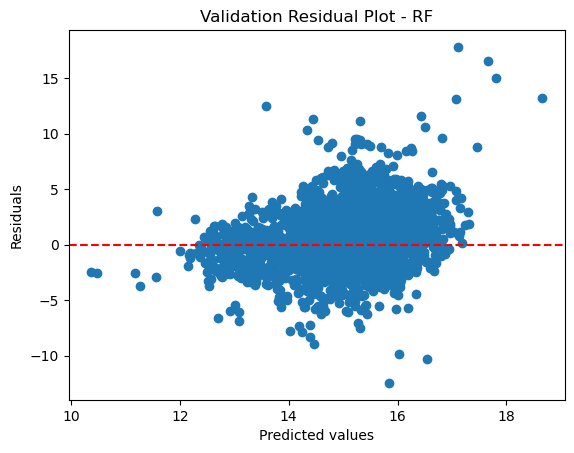

In [83]:
residuals = y_val_scaled -y_predRF

# Residual Plot
plt.scatter(y_predRF, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Validation Residual Plot - RF")
plt.show()

In [85]:
#XGBoost Regression
# Define XGBoost Regressor
warnings.filterwarnings('ignore') 

modelXGB_val = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)

# Define parameter distributions to sample from
param_distributions = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2, 1, 5],
    'min_child_weight': [1, 3, 5, 7]
}

#Define your cross-validation strategy
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)

# Set up the RandomizedSearchCV
grid_searchXGB = RandomizedSearchCV(
    estimator=modelXGB_val,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_mean_absolute_error',
    cv=cv,
    random_state=123,
    n_jobs=-1,  # Use all available cores for speed
    verbose=1   # Set to 1 or 2 to see progress messages
)

In [87]:
warnings.filterwarnings('ignore') 
grid_searchXGB.fit(X_train_scaled, y_train_scaled)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=123),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_po...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'gamma': [0, 0.1, 0.2, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 300, 500, 700,
                                                         1000],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=123, scoring='neg_mean_absolute_error',
                   verbose=1)

In [89]:
# Print Best Parameters
print(f"Best MAE (CV): {grid_searchXGB.best_score_:.3f}")
print("Best Parameters:", grid_searchXGB.best_params_)

Best MAE (CV): -1.389
Best Parameters: {'subsample': 1.0, 'n_estimators': 700, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.7}


In [91]:
# Evaluate the Best Model on Validation Set
best_model = grid_searchXGB.best_estimator_
y_predXGB = best_model.predict(X_val_scaled)

In [93]:
mse = mean_squared_error(y_val_scaled, y_predXGB)
r22 = r2_score(y_val_scaled, y_predXGB)
print(f'R-squared: {r22}')
print(f"Validation Mean Squared Error: {mse:.4f}")

R-squared: 0.12667808388956958
Validation Mean Squared Error: 7.0690


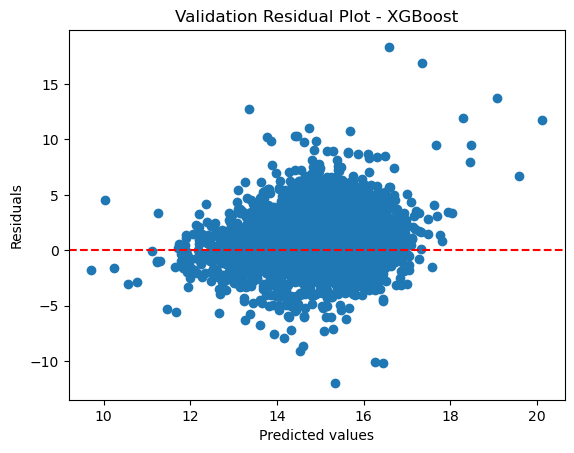

In [95]:
residuals = y_val_scaled - y_predXGB

# Residual Plot
plt.scatter(y_predXGB, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Validation Residual Plot - XGBoost")
plt.show()

In [97]:
#SVR Regression
#################### TAKES FOREVER TO RUN --> I let it go overnight ########################
# Define the SVR model
svr = SVR()

# Define parameter distributions for RandomizedSearch
param_distributions = {
    'C': np.logspace(-3, 3, 7),        # e.g. [1e-3, 1e-2, ..., 1e3]
    'epsilon': [0.001, 0.01, 0.1, 1],
    'gamma': np.logspace(-3, 1, 5),    # e.g. [1e-3, 1e-2, 1e-1, 1, 10]
    'kernel': ['rbf', 'linear']
}

# Set up the RandomizedSearchCV
random_search_svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_distributions,
    n_iter=20,                 # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=5,                      # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,                 # Use all available cores
    verbose=1
)

# Fit the RandomizedSearchCV on the training data
random_search_svr.fit(X_train_scaled, y_train_scaled)

# Print the best parameters and best score found
print("Best parameters:", random_search_svr.best_params_)
print("Best CV MSE (negative):", random_search_svr.best_score_)

# Train a final model using the best parameters
best_svr = random_search_svr.best_estimator_

# Evaluate on the Validation set
y_predSVR = best_svr.predict(X_val_scaled)
mse_Validation = mean_squared_error(y_val_scaled, y_predSVR)
r2_Validation = r2_score(y_val_scaled, y_predSVR)
print(f"Validation MSE: {mse_Validation:.3f}")
print(f"Validation R2: {r2_Validation:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.1, 'C': 1.0}
Best CV MSE (negative): -6.545973931746339
Test MSE: 6.661
Test R2: 0.177


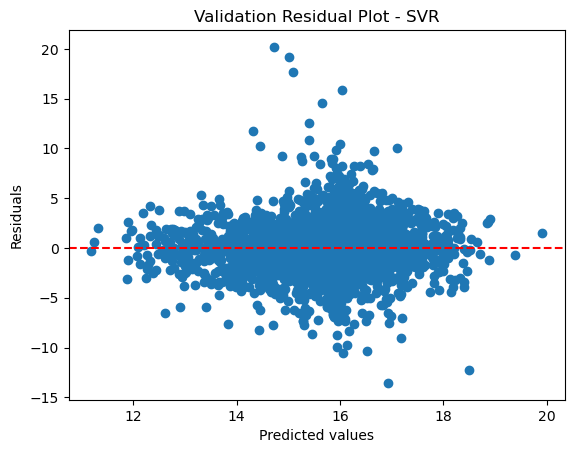

In [99]:
residuals = y_val_scaled - y_predSVR

# Residual Plot
plt.scatter(y_predSVR, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Validation Residual Plot - SVR")
plt.show()

In [ ]:
#################### TESTING ############################

In [ ]:
#Pick model from validation with the best R2/MSE 

In [103]:
scaler = StandardScaler()
scaled_Xtest = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(scaled_Xtest, columns = X_train_temp.columns)

#Transform Target Variable 
y_test_scaled = stats.yeojohnson(y_test + 1e-6, lmbda=lam)

In [105]:
# Evaluate the Best Model on Validation Set
# Use whichever model prefomed the best in validation --> here it is RF
best_modelRF = grid_searchRF.best_estimator_
y_predRF = best_modelRF.predict(X_test_scaled)

# Compute performance metrics
mae = mean_absolute_error(y_test_scaled, y_predRF )
mse = mean_squared_error(y_test_scaled, y_predRF )
rmse = mse ** 0.5  # Root Mean Squared Error
r2 = r2_score(y_test_scaled, y_predRF )

oob_score = best_modelRF.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Out-of-Bag Score: 0.47395437396655815
Test MAE: 1.879
Test RMSE: 2.513
Test R²: 0.244


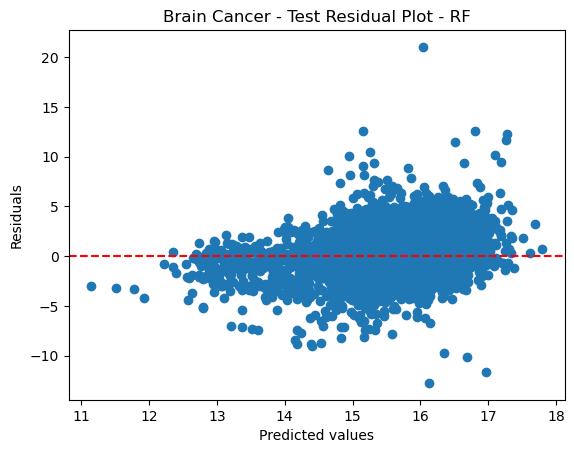

In [209]:
# Cut and Paste Residual plot into Excel sheet on 'Residual Plots' tab
residuals = y_test_scaled - y_predRF

# Residual Plot
plt.scatter(y_predRF, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Brain Cancer - Test Residual Plot - RF") #edit for correct cancer and model type
plt.show()

In [ ]:
#################### PREDICTIONS ############################

In [157]:
# Get predition data
Pest10_17 = pd.read_csv("data/pesticide_prediction_data.csv")

In [185]:
# Get list of features
features = data3.columns.tolist()
del features[0] #remove 'mx'
features_yr = ['YEAR'] + ['FIPS'] + features

# Extract the features 
PestPredYrDat = Pest10_17[features_yr]
PestPredDat = Pest10_17[features]

In [161]:
# Get Cancer Predictions from Pesticide Data
best_modelRF = grid_searchRF.best_estimator_
y_pred_transformed = best_modelRF.predict(PestPredDat)

In [193]:
# Program to back transform preditions
def inv_yeojohnson(y_trans, lmbda):
    """
    Inverse Yeo-Johnson transformation.
    
    Parameters:
        y_trans (array-like): The Yeo-Johnson transformed data.
        lmbda (float): The lambda value used in the Yeo-Johnson transformation.
    
    Returns:
        array-like: The data transformed back to the original scale.
    """
    y_trans = np.asarray(y_trans)
    x = np.zeros_like(y_trans)
    
    # For data corresponding to original nonnegative values
    pos = y_trans >= 0
    if lmbda != 0:
        x[pos] = np.power(y_trans[pos] * lmbda + 1, 1.0 / lmbda) - 1
    else:
        x[pos] = np.exp(y_trans[pos]) - 1

    # For data corresponding to original negative values
    neg = y_trans < 0
    if lmbda != 2:
        x[neg] = 1 - np.power(1 - (2 - lmbda) * y_trans[neg], 1.0 / (2 - lmbda))
    else:
        x[neg] = 1 - np.exp(-y_trans[neg])
    
    return x

In [197]:
# Back-transform the predictions to the original scale
# Note: lam is defined earlier in this code
y_pred_original = inv_yeojohnson(y_pred_transformed, lam) 

In [199]:
PestPredYrDat['cancer_type']= "Brain and nervous system cancer"  #Add in the cancer type
PestPredYrDat['predictions']= y_pred_original 
results = PestPredYrDat.drop(columns=features)

In [201]:
results.head(3)

,YEAR,FIPS,cancer_type,predictions
0,1992,101,Brain and nervous system cancer,4.735664
1,1992,103,Brain and nervous system cancer,4.781883
2,1992,105,Brain and nervous system cancer,4.759663


In [205]:
# write results to file
#results.to_csv("brain_cancer_predictions.csv")